
<div class="alert alert-block alert-success">
<b> Comentário Geral do revisor: </b> <a class="tocSkip"></a>

Tudo certo agora. Desejo sucesso na jornada. Parabéns pelo empenho.
</div>

## importando bibiliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data0= pd.read_csv('datasets/geo_data_0.csv')
data1= pd.read_csv('datasets/geo_data_1.csv')
data2= pd.read_csv('datasets/geo_data_2.csv')

## varificando dados

In [3]:
#a função imprime informações sobre o data frame
def check_data(data0,n):
    print('---------------------------------------')
    print('dados ',n)
    print('---------------------------------------')
    print(data0.head())
    print()
    data0.info()
    print()
    print('duplicados: ',data0.duplicated().sum())
    print('---------------------------------------')
    
check_data(data0,'data0')
check_data(data1,'data1')
check_data(data2,'data2')

---------------------------------------
dados  data0
---------------------------------------
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

duplicados:  0
---------------------------------------
---------------------------------------
dados  data1
---------------------------------------
      id         

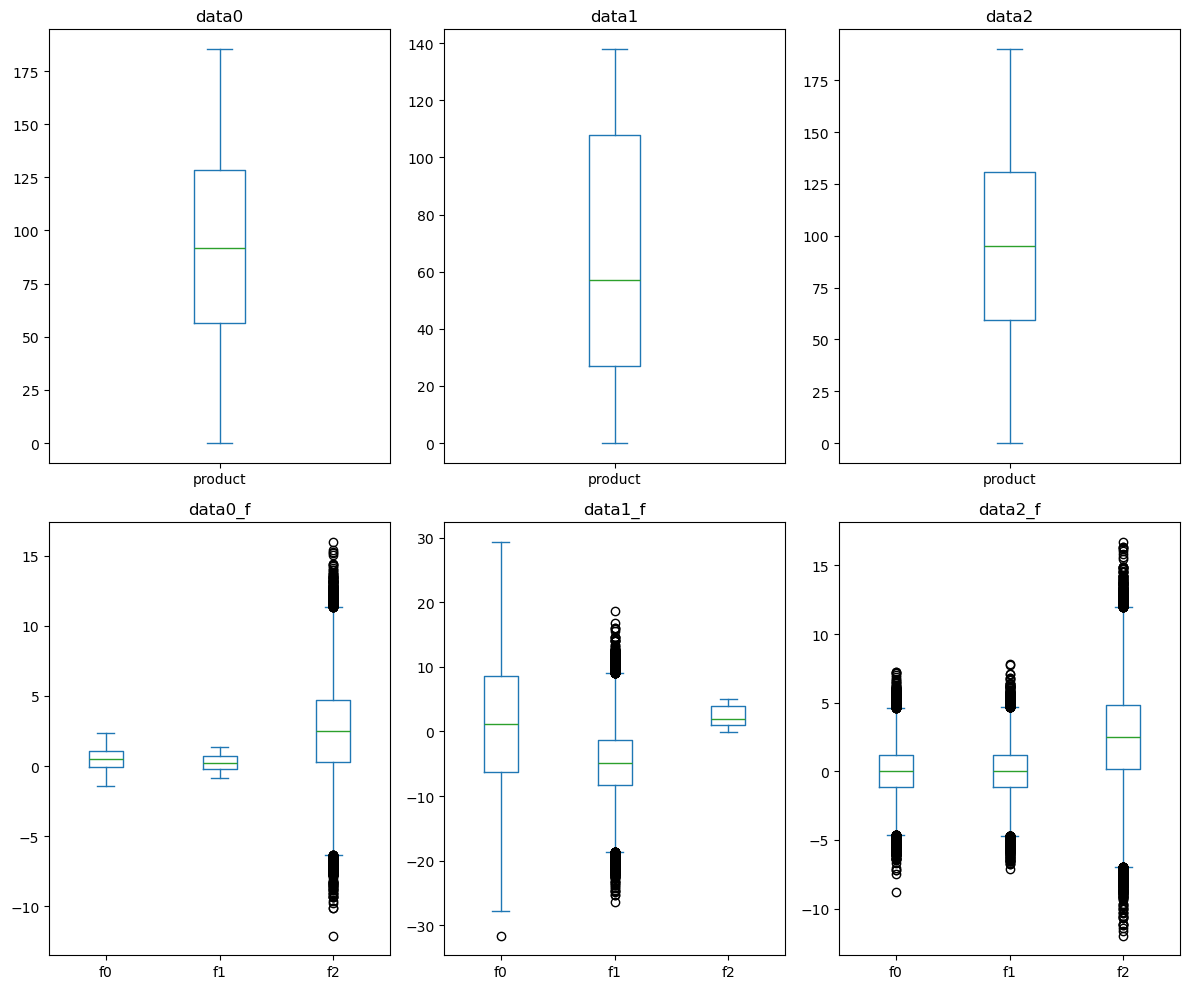

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

data0['product'].plot(kind='box', ax=axes[0,0], title='data0')
data1['product'].plot(kind='box', ax=axes[0,1], title='data1')
data2['product'].plot(kind='box', ax=axes[0,2], title='data2')

data0.drop(columns=['product'],axis=1).plot(kind='box', ax=axes[1,0], title='data0_f')
data1.drop(columns=['product'],axis=1).plot(kind='box', ax=axes[1,1], title='data1_f')
data2.drop(columns=['product'],axis=1).plot(kind='box', ax=axes[1,2], title='data2_f')

plt.tight_layout()
plt.show()

Podemos notar alguns outliers que pode afetar o desempenho da regressão linear, estes devem ser tratados para melhorar a precisão do modelo

In [5]:
# Função para substituir outliers por mediana usando IQR
def substituir_outliers_por_mediana(df, coluna):
    # Calcular o primeiro e terceiro quartil (Q1 e Q3)
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1  # Intervalo interquartil

    # Definir limites para detectar outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Calcular a mediana da coluna
    mediana = df[coluna].median()

    # Substituir valores menores que o limite inferior e maiores que o limite superior pela mediana
    df[coluna] = df[coluna].apply(lambda x: mediana if x < limite_inferior or x > limite_superior else x)

# Exemplo de uso
substituir_outliers_por_mediana(data0, 'f2')
substituir_outliers_por_mediana(data1, 'f1')
substituir_outliers_por_mediana(data2, 'f0')
substituir_outliers_por_mediana(data2, 'f1')
substituir_outliers_por_mediana(data2, 'f2')


## realizando a separação dos dados e o treinamento do modelo

In [6]:
def get_pred(data0,n):
    print('para ',n)
    #organizando alvo e caracteristicas
    target_0=data0['product']
    features_0=data0.drop(columns=['product','id'],axis=1)

    #separando grupo de treinamento e validação
    fTrain_0,fValid_0,tTrain_0,tValid_0 = train_test_split(features_0, target_0, test_size=0.25,random_state=12345)

    #treinando modelo
    model = LinearRegression()
    model.fit(fTrain_0,tTrain_0)
    
    pred_0=model.predict(fValid_0)
    
    print('volume medio previsto',pred_0.mean())
    print('REQM:',mean_squared_error(tValid_0,pred_0)**0.5)
    print()
    return pred_0 

pred_0 = get_pred(data0, 'data0')
pred_1 = get_pred(data1, 'data1')
pred_2 = get_pred(data2, 'data2')

para  data0
volume medio previsto 92.59209038975352
REQM: 37.72111383315516

para  data1
volume medio previsto 68.72873438835286
REQM: 0.8933199752470018

para  data2
volume medio previsto 95.01687348441915
REQM: 40.17223915981047



### validando quantidades para não gerar prejuizo, fazendo uso de todo os dados

In [7]:
def get_mean_region(pred):
    print(f"a região tem aproximadamente {pred.mean()/111.1:.2f} do valor minimo esperado de volume nessa região")

get_mean_region(pred_0)
get_mean_region(pred_1)
get_mean_region(pred_2)

a região tem aproximadamente 0.83 do valor minimo esperado de volume nessa região
a região tem aproximadamente 0.62 do valor minimo esperado de volume nessa região
a região tem aproximadamente 0.86 do valor minimo esperado de volume nessa região


As regiões que apresentam um maior valor de produto são a 2 e a 0 respectivamente

### separando os 200 poços mais lucrativos e verificando o lucro potencial

In [8]:
#retornar o top 200 da região
def get_top200(pred):
    #ordena em ordem descendente e pega os primeiros 200 valores (200 maiores)
    top200 = np.sort(pred)[::-1][:200]
    
    #calcula lucro potencial
    print(f"o lucro potencial para esta região levando em conta os 200 maiores poços é de: {top200.sum()*4500:.2f}" )
    
    return top200

top_0 = get_top200(pred_0)
top_1 = get_top200(pred_1)
top_2 = get_top200(pred_2)

o lucro potencial para esta região levando em conta os 200 maiores poços é de: 137227053.05
o lucro potencial para esta região levando em conta os 200 maiores poços é de: 124857648.62
o lucro potencial para esta região levando em conta os 200 maiores poços é de: 130297362.33


Levando em conta o maior lucro potencial dos melhores poços, a região 0 e a 2 são as mais indicadas para serem exploradas sendo a região 0 com maior potencial

## fazendo uso de bootstraping para calcular lucros e riscos

In [9]:
def profit(arr):
    #definindo random state fixo
    state = np.random.RandomState(12345)
    #convertendo array em df
    df = pd.DataFrame(arr, columns=['profit'])
    values = []
    
    for i in range(1000):
        subsample = df.sample(frac=1, replace=True, random_state=state)
        
        values.append(subsample['profit'].mean())
        
    values = np.array(values)
    #calculando numero de "produto"
    l=values.mean()
    #intervalo de confiança
    ci_95 = np.percentile(values, [2.5, 97.5])
    #calculando prejuizo
    RL = (values<0).mean()*100
    
    return l,ci_95,RL

l_0,ci_0,rl_0=profit(top_0)
l_1,ci_1,rl_1=profit(top_1)
l_2,ci_2,rl_2=profit(top_2)


In [10]:
print(f"lucro medio: {l_0.mean()*4500:.2f}, intervalo de confiança CI {ci_0}, rl {rl_0}")
print(f"lucro medio: {l_1.mean()*4500:.2f}, intervalo de confiança CI {ci_1}, rl {rl_1}")
print(f"lucro medio: {l_2.mean()*4500:.2f}, intervalo de confiança CI {ci_2}, rl {rl_2}")


lucro medio: 686070.99, intervalo de confiança CI [151.81870304 153.11781426], rl 0.0
lucro medio: 624284.33, intervalo de confiança CI [138.68771813 138.77288374], rl 0.0
lucro medio: 651450.94, intervalo de confiança CI [144.39978662 145.1240009 ], rl 0.0


Analisando os valores de lucro, CI e risco de prejuizo a melhor regiao para exploração seria a região 0 seguida pela 2 e por fim a 1